# Modeling - *Phragmites australis* 

All image files are stored locally.

This notebook represents initial supervised modeling efforts to classify *phragmites australis* from aerial images. To create an environment to run this code, please see the requirements.txt file. 

In [11]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import rasterio as rio
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import sklearn as sk
from sklearn.model_selection import train_test_split
import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

mpl.rcParams['figure.figsize'] = (10, 10)
mpl.rcParams['axes.titlesize'] = 20

Using TensorFlow backend.


# Import Training Data

Examination of the training data. This is from local files as the images are too large to be on Github. 

In [12]:
train_directory = './new_train_data/images/'

#GRAMA ut cty schools2019.pdf
image_path = []

for file in os.listdir(train_directory):
    filename = os.fsdecode(file)
    image_path.append(train_directory + filename)

#Sort the Files
image_path = sorted(image_path)

In [13]:
#Do the paths to the files look alright? 
image_path[48]

'./new_train_data/images/000000048.tif'

In [14]:
#Running tests on example: 000000048.tif, this image should include Phragmites
with rio.open(image_path[48], 'r+') as src:
    test_image = src.read()
    test_image_meta = src.meta
    
    #Remove the null portion of the image: 6
    test_image = test_image[:5][:][:]

In [15]:
print("The shape of the training image is {0} by {1} by {2}".format(test_image.shape[0],
                                                                    test_image.shape[1],test_image.shape[2]))

The shape of the training image is 5 by 32 by 32


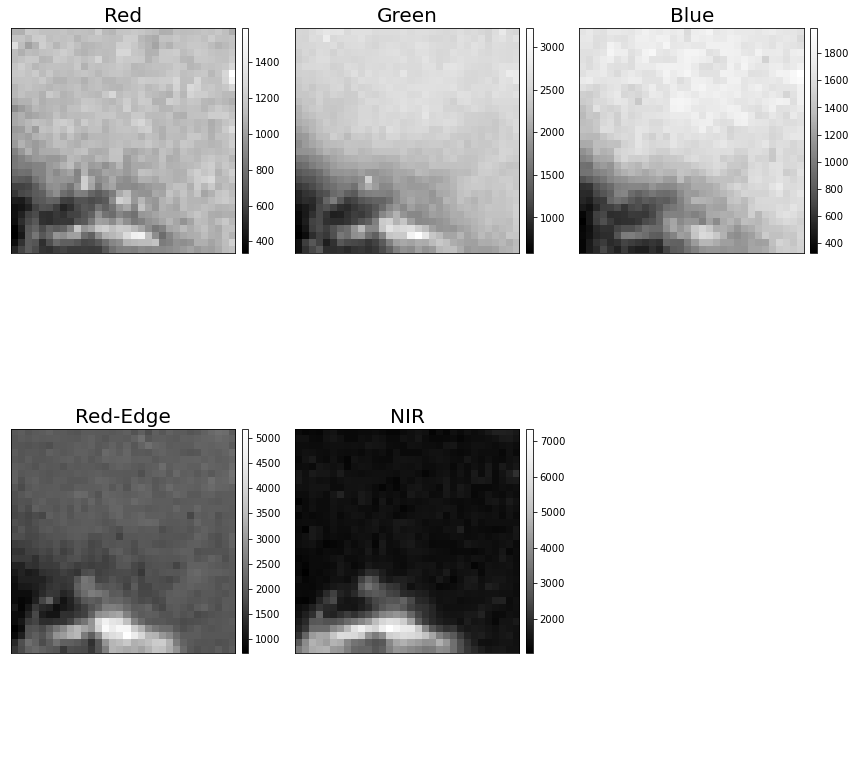

In [16]:
#Let's plot this example:
titles = ["Red", "Green", "Blue", "Red-Edge", "NIR"]
ep.plot_bands(test_image,
              scale=False,
             title=titles)
plt.show()

**Segmentation Classes:**

Within each image there are several different classes including water, soil, algae, bulrush, cattail and the invasive species of interest *Phragmites australis*. Initially, we will only try to predict this class, but in the future may move to segmentation of all labeled classes. 

In [17]:
#Let's see if we can visualize what a label looks like: 
label_directory = './new_train_data/labels/Phragmites/'
phrag_label_path = []

for file in os.listdir(label_directory):
    filename = os.fsdecode(file)
    phrag_label_path.append(label_directory + filename)

phrag_label_path = sorted(phrag_label_path)

In [18]:
#Check it matches:
print('Percentage of data with phragmites label: {0}'.format(len(phrag_label_path)/len(image_path)))

Percentage of data with phragmites label: 0.6594094840441396


In [19]:
phrag_label_path[0]

'./new_train_data/labels/Phragmites/000000048.tif'

In [20]:
#Running tests on example: 000000007
with rio.open(phrag_label_path[0], 'r+') as src:
    test_label = src.read()
    test_label_meta = src.meta

In [21]:
print("The shape of the training mask is {0} by {1} by {2}".format(test_label.shape[0],
                                                                    test_label.shape[1],test_label.shape[2]))

The shape of the training mask is 1 by 32 by 32


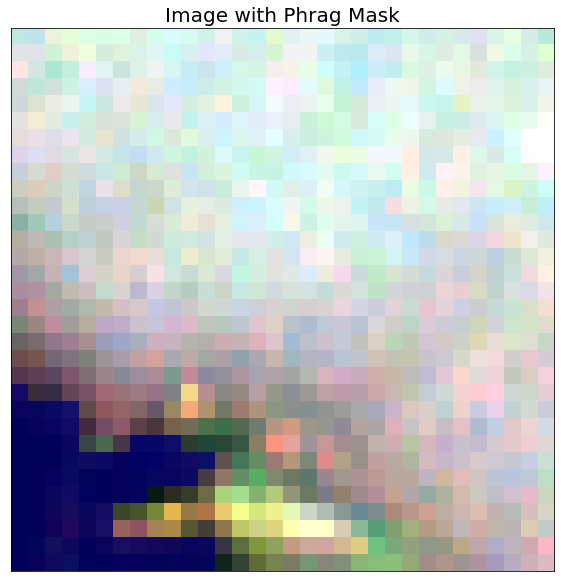

In [22]:
import numpy as np
masked = np.ma.masked_where(test_label[0] == 0, test_label[0])
f, ax = plt.subplots(1, 1)

#Plot the image
ep.plot_rgb(test_image,ax =ax,stretch = True,rgb=[0,1,2],)

#Plot the Mask
ax.imshow(masked, 'jet', interpolation='none', alpha=0.7)

#Plot settings
ax.set_title("Image with Phrag Mask")
plt.show()

**Conclusion**

Herein, we've collected the paths to both the 5x32x32 images and the corresponding 1x32x32 images. We've checked to ensure the labels correspond to images. We have selected only one class for initial training, with option to predict all classes in the future. Of note, only ~70% of images have phragmites within them. This may lead to some overfitting. We may consider using image rotations to create "new images' with no phragmites to balance the training data.  

# Data Preperation:

This step represents the collection and processing of all images. For best ease with processing in Keras, we reformat the images to be of dimension (N x X x Y x channels)

In [23]:
#Grab and process the images: 
images = []
image_name = []

for image in image_path:
    image_name.append(image.split('images/')[1])
    with rio.open(image, 'r+') as src:
        images.append(np.transpose(src.read(), (1, 2, 0)))
        
images = np.array(images)

#Take only five channels
images = images[:,:,:,:5]

In [24]:
#Data Follows format: Example number, image x pixesl, image y pixels and chanels
images.shape

(3353, 32, 32, 5)

Some masks have several layers and mixed values (0-5). This appears to simply be a result of data export from arcGIS. To correct these labels, we first flatten the matrix so it is of dimension 1x32x32 then allocate all values above 1 to become 1. This creates binary masks. 

In [25]:
phrag_masks = []
phrag_name = []

for mask in phrag_label_path:
    phrag_name.append(mask.split('Phragmites/')[1])
    
    #append the mask:
    with rio.open(mask, 'r+') as src:
        #Flatten and make anything above 1 =1 
        temp  = np.sum(src.read(),axis = 0).reshape(32,32,1)
        temp[temp>1] = 1
        phrag_masks.append(temp)

        
        
phrag_masks = np.array(phrag_masks)

#Let's Look at the shape
phrag_masks.shape

(2211, 32, 32, 1)

In [26]:
images.shape[0] - phrag_masks.shape[0]

1142

In [27]:
phrag_mask_fill = []
phrag_count = 0 

#We to back fill masks for all the images which don't have labels
for image in image_name:
    #Create null
    if image not in phrag_name:
        phrag_mask_fill.append(np.zeros([32,32,1]))
        
    #Replace otherwise
    else: 
        phrag_mask_fill.append(phrag_masks[phrag_count])
        phrag_count +=1
        
phrag_mask_fill = np.array(phrag_mask_fill)

In [28]:
phrag_mask_fill.shape

(3353, 32, 32, 1)

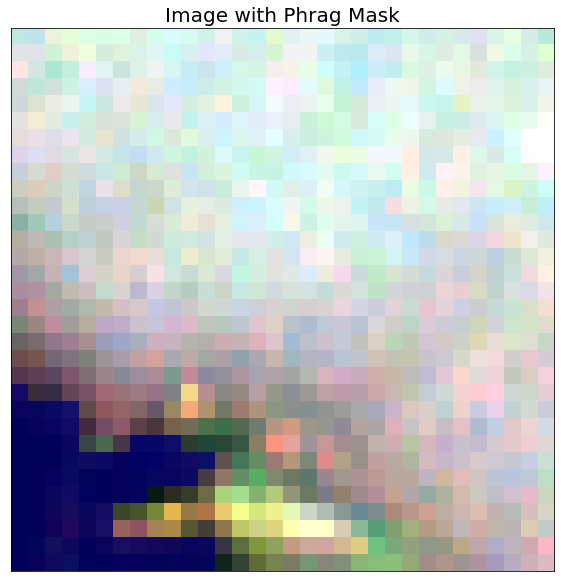

In [29]:
#Double Check!
masked = np.ma.masked_where(phrag_mask_fill[48,:,:].reshape(32,32) == 0, phrag_mask_fill[48,:,:].reshape(32,32))
f, ax = plt.subplots(1, 1)

#Plot the image
ep.plot_rgb(np.transpose(images[48], (2,0,1)),ax =ax,stretch = True,rgb=[0,1,2],)

#Plot the Mask
ax.imshow(masked, 'jet', interpolation='none', alpha=0.7)

#Plot settings
ax.set_title("Image with Phrag Mask")
plt.show()

# Descriptive Statatistics 

**How many images have the plant of interest within?**

Text(0.5, 1.0, 'Label Balance in Dataset')

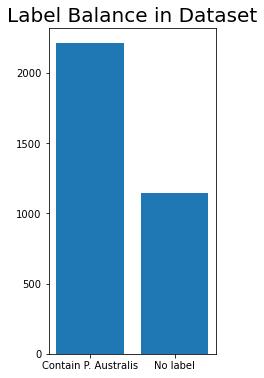

In [30]:
fig,ax = plt.subplots(1,figsize=(3, 6))
ax.bar(['Contain P. Australis','No label'],[phrag_masks.shape[0],images.shape[0]-phrag_masks.shape[0]])
ax.set_title('Label Balance in Dataset')

**Conclusion**

We have not explored the details of the data well. We will attempt to perform so more basic analysis on the images to see if there are any existing artifacts which need attention. If we introduce more classes for prediction, we will add more bar graphs as well.

# Feature Engineering: 

Currently we have no feature engineering being performed as we are simply using the raw chanel data. Some ideas we would like to implement:

1. Pixel standardization
2. Usage of other channels created by combining several of the raw features (NDVI or False composite)
3. Image alteration to increase the size training data (rotations, zoom in)


# Train/Test Split

We will perform an 80/20 split of data for training and testing respectively. This leaves 2,682 images for training and 671 images for testing. 

In [31]:
X_train, X_test, y_train, y_test = train_test_split(images, 
                                                                       phrag_mask_fill, 
                                                                       test_size=0.20, 
                                                                       random_state=42)

In [32]:
X_train.shape

(2682, 32, 32, 5)

# UNet in Keras

UNet is architecture developed by Ronneberger *et al* (https://arxiv.org/abs/1505.04597) created to segment biomedical images. It consists of an encoder and decoder. This network works by taking the image and reducing it into a high dimensional space via system of convolutions and pooling. To create the desired output, a binary segmentation mask, UNet utilizes deconvolutions to expand the high dimensional vector back to the original image dimensions allowing for creation of a high quality image mask. 

See: 
1. https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47 
2. https://www.tensorflow.org/tutorials/images/segmentation

In [34]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [35]:
def unet_v1(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Build the network
    
    #Encoder
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    #Decoder
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    #We can use a sigmoid activation function for the final layer as we are doing only one class
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [36]:
# Parameters based upon the size of the input. 
im_width = 32
im_height = 32
border = 2

In [37]:
input_img = Input((im_height, im_width,5), name='img')
model = unet_v1(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.


In [97]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 32, 32, 5)    0                                            
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 32, 32, 16)   736         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_50 (BatchNo (None, 32, 32, 16)   64          conv2d_52[0][0]                  
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 32, 32, 16)   0           batch_normalization_50[0][0]     
____________________________________________________________________________________________

In [99]:
#This allocates that the network should perform early stopping if the rate of improvement drops below 0.0001
#It saves the best performing network weights to v1_unet.h5
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('v1_unet.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [100]:
#Run the model!
results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,\
                    validation_data=(X_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 2682 samples, validate on 671 samples
Epoch 1/50
2682/2682 [==============================] - 32s 12ms/step - loss: 0.4945 - accuracy: 0.7483 - val_loss: 1.1528 - val_accuracy: 0.6123

Epoch 00001: val_loss improved from inf to 1.15281, saving model to model-tgs-salt.h5
Epoch 2/50
2682/2682 [==============================] - 32s 12ms/step - loss: 0.4099 - accuracy: 0.8103 - val_loss: 0.4486 - val_accuracy: 0.7986

Epoch 00002: val_loss improved from 1.15281 to 0.44858, saving model to model-tgs-salt.h5
Epoch 3/50
2682/2682 [==============================] - 33s 12ms/step - loss: 0.3824 - accuracy: 0.8227 - val_loss: 0.4120 - val_accuracy: 0.8103

Epoch 00003: val_loss improved from 0.44858 to 0.41199, saving model to model-tgs-salt.h5
Epoch 4/50
2682/2682 [==============================] - 42s 16ms/step - loss: 0.3756 - accuracy: 0.8256 - val_loss: 0.3556 - val_accuracy: 0.8487

Epoch 00004: val_loss improved from 0.41199 to 0.35

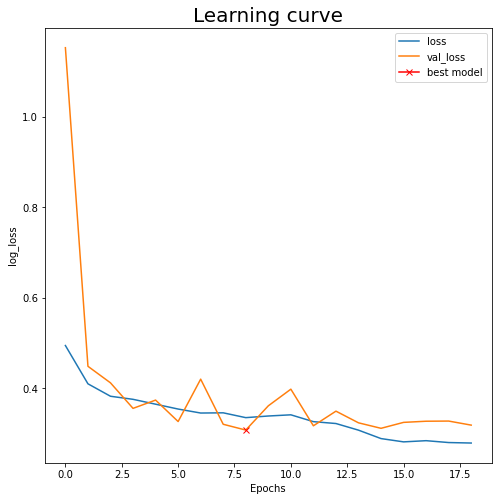

In [101]:
#Plot the loss function: See how it changes overtime
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

# Model Evaluation

In [43]:
# load the best model
model.load_weights('v1_unet.h5')

# Evaluate on validation set (this must be equals to the best log_loss)
loss,accuracy = model.evaluate(X_test, y_test, verbose=1)

671/671 [==============================] - 2s 3ms/step


In [45]:
print('The model showcases a cost function loss of: {0}'.format(loss))
print('The current pixel accuracy of this basic UNet is: {0}'.format(accuracy))

The model showcases a cost function loss of: 0.30765681064253236
The current pixel accuracy of this basic UNet is: 0.8575747013092041


In [46]:
#Visualizing predictions: 
preds_train = model.predict(X_train, verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Need binaries: 
preds_train_thres = (preds_train > 0.5).astype(np.uint16)
preds_test_thres = (preds_test > 0.5).astype(np.uint16)

671/671 [==============================] - 2s 3ms/step


In [47]:
preds_train_thres.shape

(2682, 32, 32, 1)

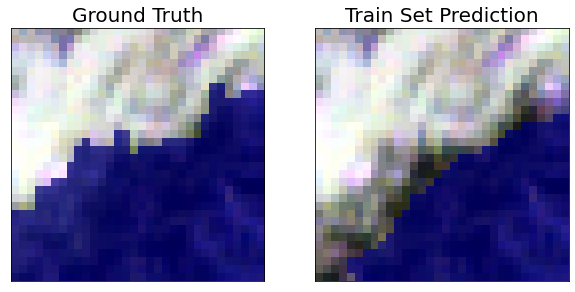

In [49]:
#Check it out
masked_pred = np.ma.masked_where(preds_train_thres[0,:,:].reshape(32,32) == 0, 
                            preds_train_thres[0,:,:].reshape(32,32))

masked_true = np.ma.masked_where(y_train[0,:,:].reshape(32,32) == 0, 
                            y_train[0,:,:].reshape(32,32))

f, (ax1,ax2) = plt.subplots(1, 2)

#Plot the image
ep.plot_rgb(np.transpose(X_train[0], (2,0,1)),ax =ax1,stretch = True,rgb=[0,1,2],)
#Plot the Mask
ax1.imshow(masked_true, 'jet', interpolation='none', alpha=0.7)
ax1.set_title('Ground Truth')

ep.plot_rgb(np.transpose(X_train[0], (2,0,1)),ax =ax2,stretch = True,rgb=[0,1,2],)
ax2.imshow(masked_pred, 'jet', interpolation='none', alpha=0.7)
ax2.set_title("Train Set Prediction")

plt.show()

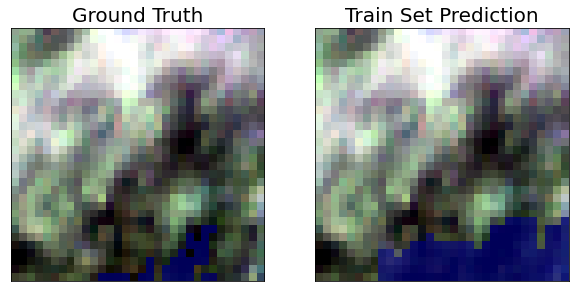

In [50]:
#Check it out
masked_pred = np.ma.masked_where(preds_test_thres[0,:,:].reshape(32,32) == 0, 
                            preds_test_thres[0,:,:].reshape(32,32))

masked_true = np.ma.masked_where(y_test[0,:,:].reshape(32,32) == 0, 
                            y_test[0,:,:].reshape(32,32))

f, (ax1,ax2) = plt.subplots(1, 2)

#Plot the image
ep.plot_rgb(np.transpose(X_test[0], (2,0,1)),ax =ax1,stretch = True,rgb=[0,1,2],)
#Plot the Mask
ax1.imshow(masked_true, 'jet', interpolation='none', alpha=0.7)
ax1.set_title('Ground Truth')

ep.plot_rgb(np.transpose(X_test[0], (2,0,1)),ax =ax2,stretch = True,rgb=[0,1,2],)
ax2.imshow(masked_pred, 'jet', interpolation='none', alpha=0.7)
ax2.set_title("Train Set Prediction")

plt.show()